In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob

In [ ]:
from google.colab import files
uploaded = files.upload()


! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d puneet6060/intel-image-classification

!unzip /content/intel-image-classification.zip

In [ ]:
train_path = '/content/seg_train/seg_train' 
test_path = '/content/seg_test/seg_test'
pred_path = '/content/seg_pred/seg_pred'

In [ ]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((64,64))
])

In [ ]:
#Apply transformation on data folders
train_ds = ImageFolder(train_path, transform=transform)
test_ds = ImageFolder(test_path, transform=transform)

In [ ]:
train_ds, test_ds

(Dataset ImageFolder
     Number of datapoints: 14034
     Root location: /content/seg_train/seg_train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
            ), Dataset ImageFolder
     Number of datapoints: 3000
     Root location: /content/seg_test/seg_test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
            ))

In [ ]:
img, label = train_ds[0]
print(f'Image Size : {img.shape}')
print(f'Label : {label}')
print(img)

Image Size : torch.Size([3, 64, 64])
Label : 0
tensor([[[0.9678, 0.9726, 0.9725,  ..., 0.9782, 0.9726, 0.9686],
         [0.9647, 0.9686, 0.9686,  ..., 0.9762, 0.9765, 0.9687],
         [0.9682, 0.9686, 0.9686,  ..., 0.9784, 0.9765, 0.9779],
         ...,
         [0.2232, 0.2040, 0.2736,  ..., 0.3043, 0.3361, 0.2881],
         [0.1866, 0.2743, 0.2844,  ..., 0.2833, 0.2370, 0.1555],
         [0.2222, 0.4151, 0.1774,  ..., 0.1568, 0.1729, 0.2018]],

        [[0.9678, 0.9726, 0.9804,  ..., 0.9782, 0.9726, 0.9686],
         [0.9647, 0.9688, 0.9765,  ..., 0.9762, 0.9765, 0.9687],
         [0.9710, 0.9765, 0.9765,  ..., 0.9784, 0.9765, 0.9779],
         ...,
         [0.2151, 0.1959, 0.2655,  ..., 0.2847, 0.3165, 0.2685],
         [0.1827, 0.2704, 0.2804,  ..., 0.2637, 0.2174, 0.1359],
         [0.2183, 0.4112, 0.1734,  ..., 0.1372, 0.1533, 0.1822]],

        [[0.9599, 0.9647, 0.9686,  ..., 0.9782, 0.9726, 0.9608],
         [0.9569, 0.9608, 0.9647,  ..., 0.9762, 0.9765, 0.9608],
         [0

In [ ]:
classes = train_ds.classes
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
class_indices = train_ds.class_to_idx
class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
class_indices = {v:k for k,v in class_indices.items()}
class_indices

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [ ]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
img.shape

torch.Size([3, 64, 64])

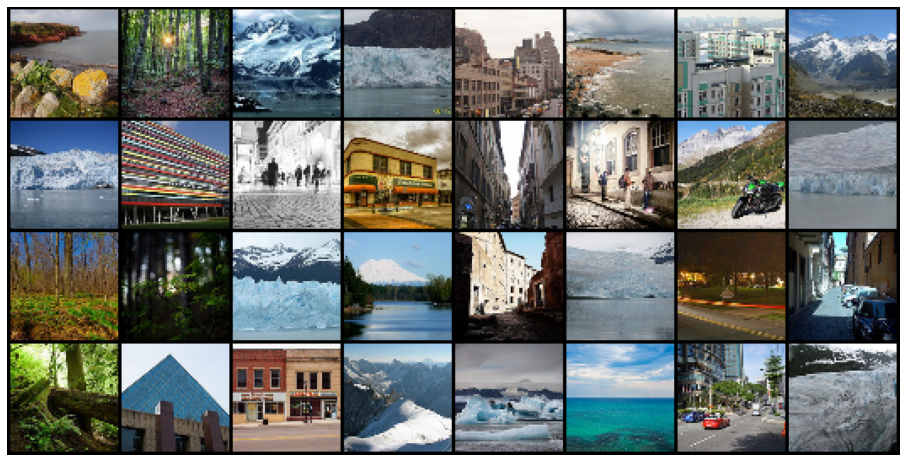

In [ ]:
for batch in train_dl:
  plt.figure(figsize=(16,20))
  img, label = batch
  plt.imshow(make_grid(img, nrow=8).permute(1,2,0)) #dimensions from 3x64x64 ===> 64x64x3
  plt.axis('off')
  break

In [ ]:
from torch.nn.modules.flatten import Flatten
from torch.nn.modules.pooling import MaxPool2d

class IntelCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),

        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
    
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.ReLU(),

        nn.Conv2d(512, 1024, kernel_size=3, padding=1),
        nn.ReLU(),

        nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
        nn.ReLU(),  
        nn.MaxPool2d(kernel_size=2),

        nn.Flatten(),
        nn.Linear(1024*8*8, 512),
        nn.ReLU(),
        nn.Linear(512, 64),
        nn.ReLU(),
        nn.Linear(64,6)
    )

  def forward(self, image):
    output = self.model(image)
    return output

In [ ]:
model = IntelCNN()
model

IntelCNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18): Conv2d(1024, 1024, kernel_size=(3, 3), strid

In [ ]:
def accuracy(pred, label):
  """
  This function calculate the accuracy. It takes:
  pred  : predictions of the model
  label : true labels for images

  return accuracy-->(float)
  """
  max_value , out_indices = torch.max(pred, dim=1)
  return torch.tensor(torch.sum(out_indices==label).item()/len(pred))

def validation_step(valid_dl, model, loss_fn):
  """
  calculate the accuracy and loss on the validation data. It takes:
  valid_dl : validation data loader
  model    : the model
  loss_fn  : loss function

  return {val_loss, val_acc}-->dict
  """
  for image, label in valid_dl:
    output = model(image)
    loss = loss_fn(output, label)
    acc = accuracy(output, label)
    return {'val_loss':loss, "val_acc":acc}

def fit(train_dl, valid_dl, epochs, optimizer, loss_fn, model):
  """
  training function. It takes:
  train_dl  : train dataloader
  valid_dl  : valid dataloader
  epochs    : number of epochs
  optimizer : model's optimizer
  loss_fn   : loss function
  model     : model

  return history of the model which contains (loss, val_loss and val_acc)-->list
  """
  history = []
  for epoch in range(1, epochs+1):
    for image,label in train_dl:
      output = model(image)
      loss = loss_fn(output, label)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    val = validation_step(valid_dl, model, loss_fn)
    print(f"Epoch [{epoch}/{epochs}] ==> loss: {loss}, val_loss:{val['val_loss']}, val_acc: {val['val_acc']}")
    history.append({'loss':loss,
                    'val_loss': val['val_loss'],
                    'val_acc':val['val_acc']
                    })
  return history

def to_device(data, device):
  """
  save data to available device such cpu or gpu. It takes:
  data   : list, tuple, data loader
  device : takes 'cpu' or 'gpu'
  """
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for x in self.dl:
      yield to_device(x, self.device)

In [ ]:
device='cuda'
model = model.to(device)
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 20
history = fit(train_dl, test_dl, epochs, optimizer, loss_fn, model)

Epoch [1/20] ==> loss: 0.7268713116645813, val_loss:1.021103024482727, val_acc: 0.53125
Epoch [2/20] ==> loss: 1.1384469270706177, val_loss:0.7555671334266663, val_acc: 0.65625
Epoch [3/20] ==> loss: 0.6134381890296936, val_loss:0.7661319375038147, val_acc: 0.65625
Epoch [4/20] ==> loss: 0.7339143753051758, val_loss:0.653178870677948, val_acc: 0.8125
Epoch [5/20] ==> loss: 0.7660999894142151, val_loss:0.8039495348930359, val_acc: 0.8125
Epoch [6/20] ==> loss: 0.76595538854599, val_loss:0.6724212169647217, val_acc: 0.78125
Epoch [7/20] ==> loss: 1.0890069007873535, val_loss:0.6826919913291931, val_acc: 0.75
Epoch [8/20] ==> loss: 0.5835122466087341, val_loss:0.6131792068481445, val_acc: 0.78125
Epoch [9/20] ==> loss: 0.22963912785053253, val_loss:0.27396100759506226, val_acc: 0.875
Epoch [10/20] ==> loss: 0.6029660105705261, val_loss:0.3918997049331665, val_acc: 0.84375
Epoch [11/20] ==> loss: 0.2405887246131897, val_loss:1.2035140991210938, val_acc: 0.71875
Epoch [12/20] ==> loss: 0.12

In [ ]:
history

[{'loss': tensor(0.7269, device='cuda:0', grad_fn=<NllLossBackward0>),
  'val_loss': tensor(1.0211, device='cuda:0', grad_fn=<NllLossBackward0>),
  'val_acc': tensor(0.5312)},
 {'loss': tensor(1.1384, device='cuda:0', grad_fn=<NllLossBackward0>),
  'val_loss': tensor(0.7556, device='cuda:0', grad_fn=<NllLossBackward0>),
  'val_acc': tensor(0.6562)},
 {'loss': tensor(0.6134, device='cuda:0', grad_fn=<NllLossBackward0>),
  'val_loss': tensor(0.7661, device='cuda:0', grad_fn=<NllLossBackward0>),
  'val_acc': tensor(0.6562)},
 {'loss': tensor(0.7339, device='cuda:0', grad_fn=<NllLossBackward0>),
  'val_loss': tensor(0.6532, device='cuda:0', grad_fn=<NllLossBackward0>),
  'val_acc': tensor(0.8125)},
 {'loss': tensor(0.7661, device='cuda:0', grad_fn=<NllLossBackward0>),
  'val_loss': tensor(0.8039, device='cuda:0', grad_fn=<NllLossBackward0>),
  'val_acc': tensor(0.8125)},
 {'loss': tensor(0.7660, device='cuda:0', grad_fn=<NllLossBackward0>),
  'val_loss': tensor(0.6724, device='cuda:0', gra

In [ ]:
train_loss = [x['loss'] for x in history]
val_loss = [x['val_loss'] for x in history]
val_acc = [x['val_acc'] for x in history]

In [ ]:
val_loss

[tensor(1.0211, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.7556, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.7661, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.6532, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.8039, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.6724, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.6827, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.6132, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.2740, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.3919, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.2035, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.3593, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.5948, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.8756, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.7668, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.2800, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

In [ ]:
train_loss = [x.item() for x in train_loss]
val_loss = [x.item() for x in val_loss]
val_acc = [x.item() for x in val_acc]

In [ ]:
val_loss

[1.021103024482727,
 0.7555671334266663,
 0.7661319375038147,
 0.653178870677948,
 0.8039495348930359,
 0.6724212169647217,
 0.6826919913291931,
 0.6131792068481445,
 0.27396100759506226,
 0.3918997049331665,
 1.2035140991210938,
 0.3592882454395294,
 0.5948324799537659,
 0.8755516409873962,
 0.7667667269706726,
 0.28003665804862976,
 1.1097320318222046,
 0.8696250915527344,
 0.545927107334137,
 0.667298436164856]

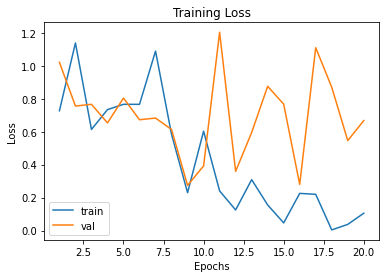

In [ ]:
epoch = list(range(1, 21))
plt.plot(epoch, train_loss)
plt.plot(epoch, val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(['train', 'val']);

Text(0.5, 1.0, 'Validation Accuracy')

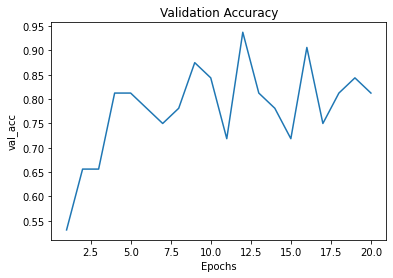

In [ ]:
epoch = list(range(1, 21))
plt.plot(epoch, val_acc)
plt.xlabel('Epochs')
plt.ylabel('val_acc')
plt.title('Validation Accuracy')

In [ ]:
def evaluate(image):
  output = model(image)
  max_value, out_indices = torch.max(output, dim=1)
  return out_indices

In [ ]:
test_data = glob.glob(pred_path+'/*')
test_data[:5]

['/content/seg_pred/seg_pred/4190.jpg',
 '/content/seg_pred/seg_pred/11633.jpg',
 '/content/seg_pred/seg_pred/17979.jpg',
 '/content/seg_pred/seg_pred/24028.jpg',
 '/content/seg_pred/seg_pred/1053.jpg']

In [ ]:
ds = []
for img_path in test_data:
  img = plt.imread(img_path)
  ds.append(transform(img))

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [ ]:
pred_dl = DataLoader(ds, batch_size=32, pin_memory=True, num_workers=8)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
pred_dl = DeviceDataLoader(pred_dl, device)

In [ ]:
preds = []
for img in pred_dl:
  output = model(img)
  max_value, out_indices = torch.max(output, dim=1)
  preds.extend(out_indices.to('cpu').numpy())

In [ ]:
preds[:15]

[1, 5, 5, 1, 0, 3, 2, 3, 3, 0, 0, 3, 3, 2, 0]

In [ ]:
classes_preds = [class_indices[i] for i in preds]
classes_preds[:15]

['forest',
 'street',
 'street',
 'forest',
 'buildings',
 'mountain',
 'glacier',
 'mountain',
 'mountain',
 'buildings',
 'buildings',
 'mountain',
 'mountain',
 'glacier',
 'buildings']

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


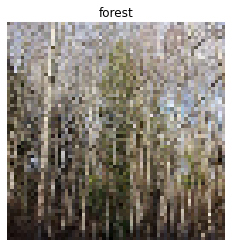

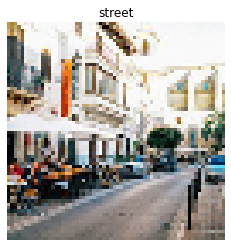

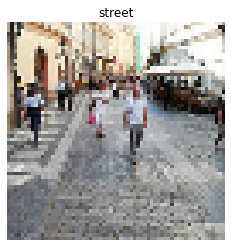

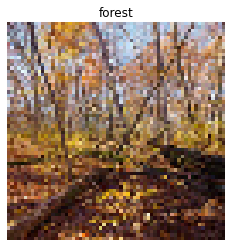

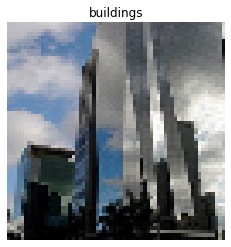

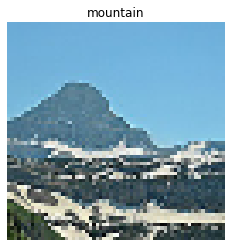

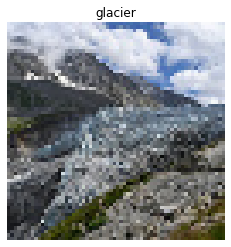

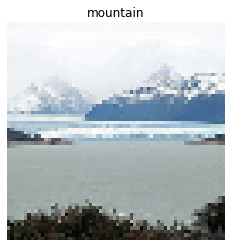

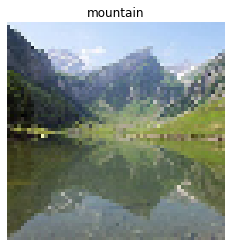

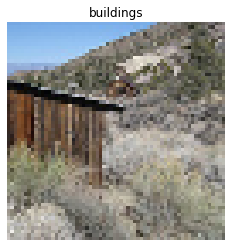

In [ ]:
for batch in pred_dl:
  for i in range(0, 10):
    plt.imshow(batch[i].to('cpu').permute(1,2,0))
    plt.title(classes_preds[i])
    plt.axis('off');
    plt.show()
  break